I've logged an issue for this bug on GitHub:
https://github.com/SciTools/cartopy/issues/655

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris
import iris.quickplot as qplt
import numpy

## Load the data

In [2]:
with iris.FUTURE.context(cell_datetime_objects=True):
    cube = iris.load_cube('example_data.nc', 'rotated_northward_wind')

cube = iris.util.squeeze(cube)
print cube

rotated_northward_wind / (m s**-1)  (latitude: 241; longitude: 480)
     Dimension coordinates:
          latitude                           x               -
          longitude                          -               x
     Scalar coordinates:
          time: 2006-06-22 06:00:00
     Attributes:
          CDI: Climate Data Interface version 1.6.3 (http://code.zmaw.de/projects/cdi...
          CDO: Climate Data Operators version 1.6.3 (http://code.zmaw.de/projects/cdo...
          Conventions: CF-1.0
          history: Tue Aug 04 12:29:59 2015: cdo seldate,2006-06-22 ../data_processing/test_vrot.nc...
          invalid_standard_name: rotated_northward_wind
          level: 500hPa
          nco_openmp_thread_number: 1
          notes: North Pole at lat=20.0, lon=260.0. Data defined on rotated grid.


## Show the data

In [3]:
cmap = 'RdBu_r'
ticks = numpy.arange(-32, 36, 4)

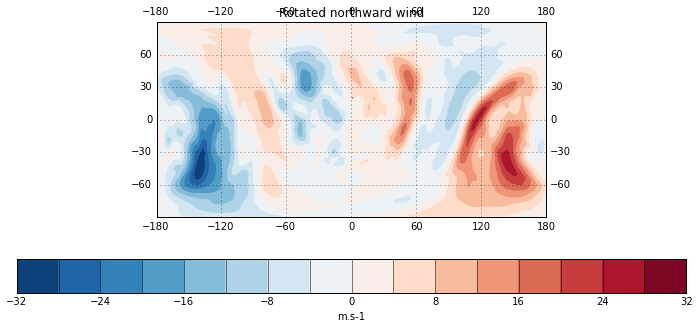

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(12, 5))

ax = plt.subplot(111)
qplt.contourf(cube, cmap=cmap, levels=ticks)
plt.gca().gridlines(draw_labels=True)

qplt.show()

## Plot on rotated grid

The latitude/longitude grid in the input file actually refers to rotated grid (`ccrs.RotatedPole(260, 20)`), so I want to plot the data on that grid...

In [5]:
def create_plot(cube, in_proj, out_proj, method):
   
    fig = plt.figure(figsize=(12, 5))

    ax = plt.subplot(111, projection=out_proj)
    x = cube.coord('longitude').points
    y = cube.coord('latitude').points

    
    if method == 'contourf':
        cf = ax.contourf(x, y, cube.data, levels=ticks, cmap=cmap,
                         transform=in_proj)
    elif method == 'pcolormesh':
        cf = ax.pcolormesh(x, y, cube.data, vmin=ticks[0], vmax=ticks[-1], cmap=cmap,
                           transform=in_proj)
    
    plt.colorbar(cf)
    plt.gca().coastlines()

    plt.show()

`contourf` works fine for the default central rotated longitude...

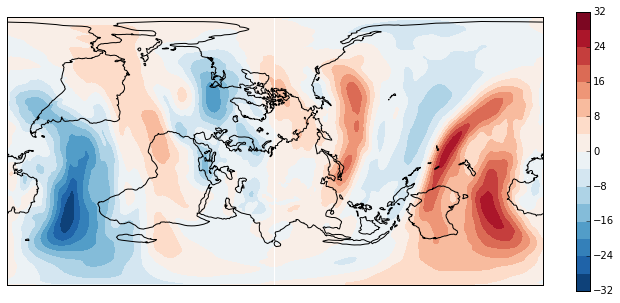

In [6]:
in_proj = ccrs.RotatedPole(260, 20)
out_proj = ccrs.RotatedPole(260, 20)

create_plot(cube, in_proj, out_proj, 'contourf')

But I want to move the central rotated longitude to better highlight the important aspects of the data. This works fine for a `pcolormesh` plot...

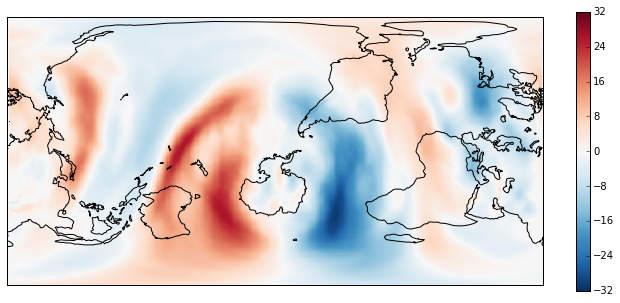

In [7]:
in_proj = ccrs.RotatedPole(260, 20)
out_proj = ccrs.RotatedPole(260, 20, central_rotated_longitude=180)

create_plot(cube, in_proj, out_proj, 'pcolormesh')

But fails for a `contourf` plot... 

In [8]:
in_proj = ccrs.RotatedPole(260, 20)
out_proj = ccrs.RotatedPole(260, 20, central_rotated_longitude=180)

create_plot(cube, in_proj, out_proj, 'contourf')

RuntimeError: Unidentified problem with geometry, linestring being re-added. Please raise an issue.

I can successfully move the central rotated longitude on contourf plots using different data files, but I can't for the life of me figure out why this particular file isn't working!

The only solution I've been able to come up with is to regrid the data to the same/similar grid, which is an ugly work-around that I'd like to avoid if possible...

In [9]:
def make_grid():
    """Make a dummy cube with desired grid."""
    
    lat_values = numpy.arange(-90, 91, 1)
    lon_values = numpy.arange(0, 360, 1)
    coordsys = iris.coord_systems.RotatedGeogCS(20, 260)
    
    latitude = iris.coords.DimCoord(lat_values,
                                    standard_name='latitude',
                                    units='degrees_north',
                                    coord_system=coordsys)
    longitude = iris.coords.DimCoord(lon_values,                     
                                     standard_name='longitude',
                                     units='degrees_east',
                                     coord_system=coordsys)

    dummy_data = numpy.zeros((len(lat_values), len(lon_values)))
    new_cube = iris.cube.Cube(dummy_data, dim_coords_and_dims=[(latitude, 0), (longitude, 1)])
    
    return new_cube

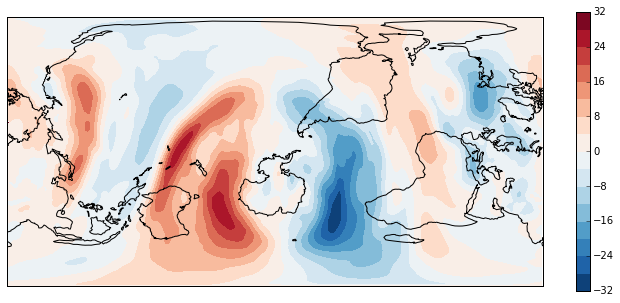

In [10]:
# Regrid
target_grid_cube = make_grid()
scheme = iris.analysis.Linear()
cube.coords('latitude')[0].coord_system = iris.coord_systems.RotatedGeogCS(20, 260)
cube.coords('longitude')[0].coord_system = iris.coord_systems.RotatedGeogCS(20, 260)
cube_regridded = cube.regrid(target_grid_cube, scheme)

# Plot
in_proj = ccrs.RotatedPole(260, 20)
out_proj = ccrs.RotatedPole(260, 20, central_rotated_longitude=180)
create_plot(cube_regridded, in_proj, out_proj, 'contourf')